# Mamoas Detection
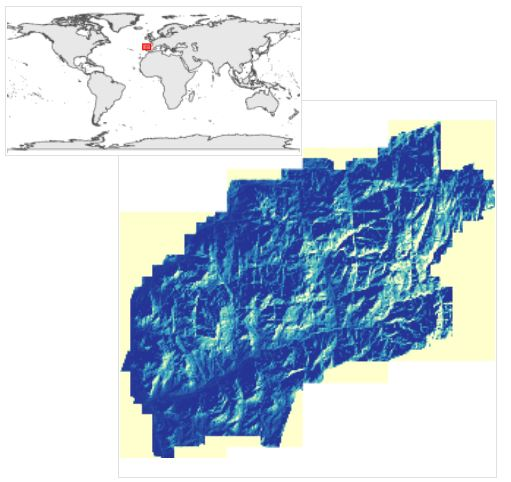

In [ ]:
!python -m pip show tensorflow

In [2]:
# Import relevant libraries
from tensorflow.keras.layers import Input, Activation, ZeroPadding2D, Lambda, Dense, Flatten,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import shutil
from os.path import exists
import seaborn as sns
import random
import ee
from PIL import Image

## Image Pre-Processing

In [4]:
# read all images of classes and convert .tif to .jpg format
path = "C:\\Users\\fabri\\Downloads\\folder data\\dataset_cnn\\"
dimention = 40
data = []
width = dimention
height = dimention
dim = (width, height)

labels = ['mamoa', 'not_mamoa']
        
if(os.path.exists(path)):  
    for label in labels:
        p = os.path.join(path, label)
        class_num = labels.index(label)
        for img in os.listdir(p):
          img_array = cv2.imread(os.path.join(p,img), cv2.IMREAD_GRAYSCALE)
          resized = cv2.resize(img_array, dim, interpolation = cv2.INTER_AREA)
          data.append([resized, class_num])
else:
    print("This directory: "+path+" doesn't exist.")
# shuffle the dataset
random.shuffle(data)

# extract the features and label
x = []
y = []
for features, label in data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, height, width, 1)
y = np.array(y)

# Normalize the values of features
x = x/255

C:\Users\fabri\anaconda3\envs\env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

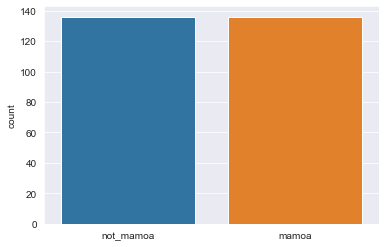

In [5]:
count = []
for i in range(0, len(data)):
    if (data[i][1] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')

sns.set_style('darkgrid')
sns.countplot(count)

# examples of two classes
#plt.figure(figsize = (5,5))
#plt.imshow(x[2], cmap='gray')
#if y[2] == 0: plt.title('mamoa')
#else: plt.title('not mamoa')

#plt.figure(figsize = (5,5))
#plt.imshow(x[10], cmap='gray')
#if y[10] == 0: plt.title('mamoa')
#else: plt.title('not mamoa')
 

## Train-Test-Val split

train, val, test: (190, 40, 40, 1) (41, 40, 40, 1) (41, 40, 40, 1)


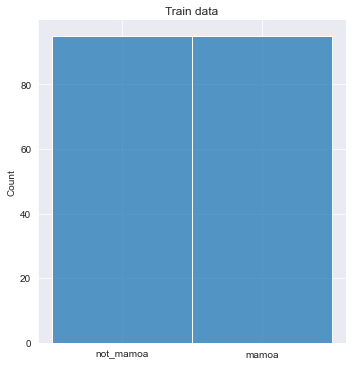

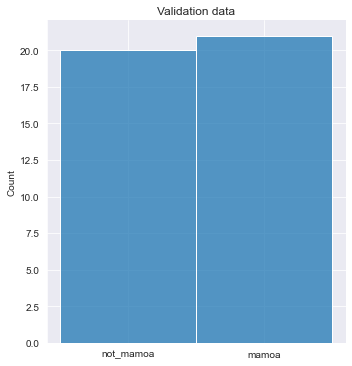

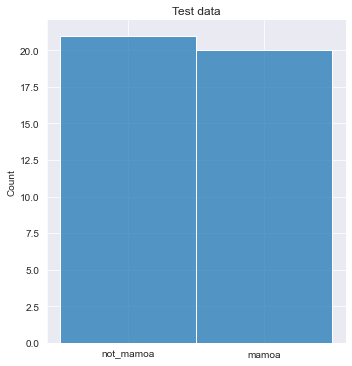

In [11]:
# split the dataset in train, validation and test using 60, 20, 20, respectively  change: 70, 15, 15
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7, test_size=0.3, random_state=None)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5, random_state=None)

print("train, val, test:",x_train.shape,x_val.shape,x_test.shape)

count = []
for i in range(0, len(y_train)):
    if (y_train[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Train data") 

count = []
for i in range(0, len(y_val)):
    if (y_val[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Validation data") 

count = []
for i in range(0, len(y_test)):
    if (y_test[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Test data") 

## Model Building

In [25]:
def MamoasModel(input_shape):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    
    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    

    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    #X = ZeroPadding2D((3, 3))(X)
    #X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    #X = Activation('relu')(X)
    #X = MaxPooling2D((2, 2), name='max_pool1')(X)
        
    # BLOCK N3: CONV -> BN -> RELU -> MAXP
    #X = ZeroPadding2D((3, 3))(X)
    #X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    #X = Activation('relu')(X)
    #X = MaxPooling2D((2, 2), name='max_pool2')(X)
        
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='Model')
    
    return model

In [26]:
model = MamoasModel((height, width, 1))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ["accuracy"])
model.summary()

# plots the model in a nice layout and save it as ".png"
plot_model(model, to_file='model.png')

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 46, 46, 1)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 40, 40, 32)        1600      
                                                                 
 bn0 (BatchNormalization)    (None, 40, 40, 32)        128       
                                                                 
 activation_5 (Activation)   (None, 40, 40, 32)        0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 20, 20, 32)        0         
                                                             

## Model Evaluation

In [27]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=100) # patience 20, epoch 200

history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=300,callbacks=[early_stop],shuffle=True)

model.save("model.h5")
print("Saved model")

Epoch 1/300
6/6 [==============================] - 1s 87ms/step - loss: 1.2732 - accuracy: 0.6000 - val_loss: 0.6493 - val_accuracy: 0.5122
Epoch 2/300
6/6 [==============================] - 0s 59ms/step - loss: 0.4806 - accuracy: 0.8000 - val_loss: 0.6237 - val_accuracy: 0.5854
Epoch 3/300
6/6 [==============================] - 0s 70ms/step - loss: 0.3486 - accuracy: 0.8947 - val_loss: 0.5392 - val_accuracy: 0.7073
Epoch 4/300
6/6 [==============================] - 0s 47ms/step - loss: 0.2914 - accuracy: 0.9053 - val_loss: 0.5616 - val_accuracy: 0.7561
Epoch 5/300
6/6 [==============================] - 0s 46ms/step - loss: 0.2390 - accuracy: 0.8895 - val_loss: 0.5882 - val_accuracy: 0.6829
Epoch 6/300
6/6 [==============================] - 0s 48ms/step - loss: 0.1600 - accuracy: 0.9421 - val_loss: 0.5235 - val_accuracy: 0.7805
Epoch 7/300
6/6 [==============================] - 0s 48ms/step - loss: 0.1470 - accuracy: 0.9526 - val_loss: 0.5539 - val_accuracy: 0.7805
Epoch 8/300
6/6 [===

6/6 [==============================] - 0s 50ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.5545 - val_accuracy: 0.8780
Epoch 118/300
6/6 [==============================] - 0s 52ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5778 - val_accuracy: 0.8780
Epoch 119/300
6/6 [==============================] - 0s 48ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.5838 - val_accuracy: 0.8780
Epoch 120/300
6/6 [==============================] - 0s 48ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5898 - val_accuracy: 0.8780
Epoch 121/300
6/6 [==============================] - 0s 51ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5999 - val_accuracy: 0.8537
Epoch 122/300
6/6 [==============================] - 0s 50ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5861 - val_accuracy: 0.8780
Epoch 123/300
6/6 [==============================] - 0s 57ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.8780
Epoch 124/300
6/6 [=

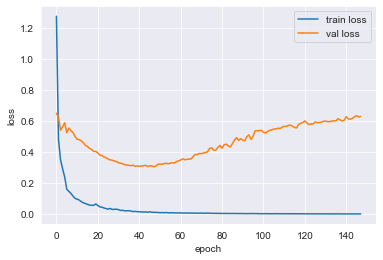

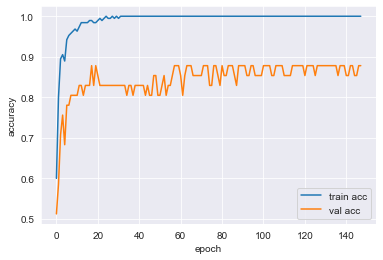

In [28]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss-graph.png')
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc-graph.png')
plt.show()

In [29]:
#Test the model on train data  
preds = model.evaluate(x = x_train, y = y_train)

print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))
print()

#Test the model on validation data  
preds = model.evaluate(x = x_val, y = y_val)

print ("Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))
print()

#Test the model on test data  
preds = model.evaluate(x = x_test, y = y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
print()

6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000
Loss = 0.0013435111613944173
Train Accuracy = 1.0

2/2 [==============================] - 0s 6ms/step - loss: 0.6284 - accuracy: 0.8780
Loss = 0.628411054611206
Validation Accuracy = 0.8780487775802612

2/2 [==============================] - 0s 9ms/step - loss: 0.0662 - accuracy: 0.9756
Loss = 0.06619816273450851
Test Accuracy = 0.9756097793579102



              precision    recall  f1-score   support

       mamoa       0.90      0.86      0.88        21
   not_mamoa       0.86      0.90      0.88        20

    accuracy                           0.88        41
   macro avg       0.88      0.88      0.88        41
weighted avg       0.88      0.88      0.88        41



<AxesSubplot:>

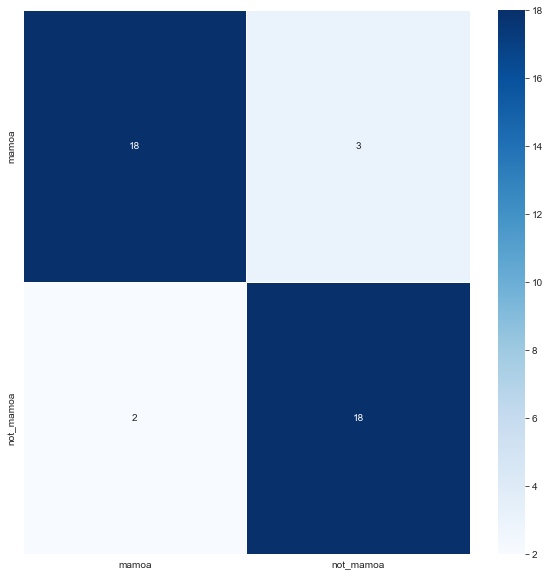

In [30]:
y_val_pred = model.predict(x_val)
#y_val_pred=np.argmax(y_val_pred, axis=1)
predict = []
for i in y_val_pred:
    if i[0] >= 0.5:
        predict.append(1)
    else:
        predict.append(0)
y_val_pred = np.array(predict)

target_names = ['mamoa', 'not_mamoa']
print(classification_report(y_val, y_val_pred, target_names = target_names))

conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix = pd.DataFrame(conf_matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, cmap= "Blues", linewidth = 1 , annot = True, fmt='g',xticklabels = labels,yticklabels = labels)

              precision    recall  f1-score   support

       mamoa       1.00      0.95      0.97        20
   not mamoa       0.95      1.00      0.98        21

    accuracy                           0.98        41
   macro avg       0.98      0.97      0.98        41
weighted avg       0.98      0.98      0.98        41



<AxesSubplot:>

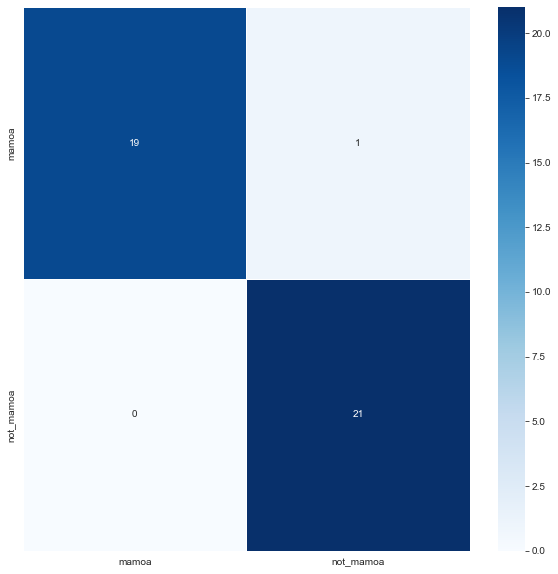

In [31]:
y_test_pred = model.predict(x_test)

#y_test_pred=np.argmax(y_test_pred, axis=1)
predict = []
for i in y_test_pred:
    if i[0] >= 0.5:
        predict.append(1)
    else:
        predict.append(0)
y_test_pred = np.array(predict)

target_names = ['mamoa', 'not mamoa']
print(classification_report(y_test, y_test_pred, target_names = target_names))

conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix = pd.DataFrame(conf_matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, cmap= "Blues", linewidth = 1 , annot = True, fmt='g',xticklabels = labels,yticklabels = labels)

# Predict in LRM - Local Relief Model

In [16]:
model = load_model('model.h5')

In [17]:
# Authentication of google earth engine to access some files as example the local relief model
ee.Authenticate()
# Initialization of google earth engine
ee.Initialize()

Enter verification code: 4/1AX4XfWiC02ZoyC4cr88iqzIErjryKSqmX_oKaRPIbIiKYanqOLndIufSOhw

Successfully saved authorization token.


In [18]:
LRM = ee.Image('users/fabriziobotelho/tiff_files')
geometry = LRM.geometry()
lrm_info = LRM.getInfo()
print(lrm_info) #debug

#geo-coordinates of upper left and lower right corners of LRM image
upper_left = [-8.907277129492169,42.16335245423417]
lower_right = [-8.06051504207768,41.59280385023923]

points = ee.Geometry.MultiPoint([upper_left, lower_right])

{'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [69977, 63086], 'crs': 'EPSG:3763', 'crs_transform': [1, 0, -63978.5, 0, -1, 277085.5]}, {'id': 'b2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [69977, 63086], 'crs': 'EPSG:3763', 'crs_transform': [1, 0, -63978.5, 0, -1, 277085.5]}, {'id': 'b3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [69977, 63086], 'crs': 'EPSG:3763', 'crs_transform': [1, 0, -63978.5, 0, -1, 277085.5]}, {'id': 'b4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [69977, 63086], 'crs': 'EPSG:3763', 'crs_transform': [1, 0, -63978.5, 0, -1, 277085.5]}], 'version': 1644944174622534, 'id': 'users/fabriziobotelho/tiff_files', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-8.900443739793436, 41.59280407757193], [-8.90044

In [19]:
#this function gets the dimention in pixel of LRM image
def getDimentionsImage(img):
  imgDescription = ee.Algorithms.Describe(img)
  w = ee.List(ee.Dictionary(ee.List(ee.Dictionary(imgDescription).get("bands")).get(0)).get("dimensions")).get(0)
  w = w.getInfo()
  h = ee.List(ee.Dictionary(ee.List(ee.Dictionary(imgDescription).get("bands")).get(0)).get("dimensions")).get(1)
  h = h.getInfo()

  return w, h

#this function uses the equations before obtained to convert a geo-coordinate to pixel coordinate
def convert_GeoCoord_to_PixelCoord(geocoordinate, m1, m2, b1, b2):
  x_geo = geocoordinate[0]
  y_geo = geocoordinate[1]
  x = round(x_geo * m1 + b1)
  y = round(y_geo * m2 + b2)
  
  return x, y

#this function is the inverse of the previous function, with it we can get the geo-coordinates that corresponds to the pixel coordinates
def convert_PixelCoord_to_GeoCoord(pixelcoordinate, m1, m2, b1, b2):
  x = pixelcoordinate[0]
  y = pixelcoordinate[1]
  x_geo = (x - b1)/m1
  y_geo = (y - b2)/m2
  
  return x_geo, y_geo

In [20]:
width, height = getDimentionsImage(LRM)
width, height

(69977, 63086)

In [21]:
x_geo1 = upper_left[0]
y_geo1 = upper_left[1]
x_geo2 = lower_right[0]
y_geo2 = lower_right[1]

x1 = 0;
y1 = 0;
x2 = width - 1 
y2 = height - 1

#equations to convert geo-coordinates to pixel coordinates
#x = x_geo * m1 + b1
#y = y_geo * m2 + b2

m1 = (x1 - x2)/(x_geo1 - x_geo2)
b1 = x1 - x_geo1 * m1
print('m1:', m1, 'b1:', b1)

m2 = (y1 - y2)/(y_geo1 - y_geo2)
b2 = y1 - y_geo1 * m2
print('m2:', m2, 'b2:', b2)

m1: 82639.5052873298 b1: 736092.9754383798
m2: -110569.01998932785 b2: 4661960.560329294


In [22]:
# create just a block with mamoas of laboreiro region to analyse the model performance

geometria = ee.Geometry.Polygon([[[-8.143058475037481,42.026511966913404],
                                    [-8.0616909823617,42.026511966913404],
                                    [-8.0616909823617,42.082594290923005],
                                    [-8.143058475037481,42.082594290923005],
                                    [-8.143058475037481,42.026511966913404]]])

LRM = LRM.clip(geometria)
upper_left = [-8.143058475037481,42.082594290923005]
lower_right = [-8.0616909823617,42.026511966913404]

points = ee.Geometry.MultiPoint([upper_left, lower_right])
width, height = getDimentionsImage(LRM)
x_geo1 = upper_left[0]
y_geo1 = upper_left[1]
x_geo2 = lower_right[0]
y_geo2 = lower_right[1]

x1 = 0;
y1 = 0;
x2 = width - 1 
y2 = height - 1

#equations to convert geo-coordinates to pixel coordinates
#x = x_geo * m1 + b1
#y = y_geo * m2 + b2

m1 = (x1 - x2)/(x_geo1 - x_geo2)
b1 = x1 - x_geo1 * m1
print('m1:', m1, 'b1:', b1)

m2 = (y1 - y2)/(y_geo1 - y_geo2)
b2 = y1 - y_geo1 * m2
print('m2:', m2, 'b2:', b2)

width, height


m1: 82821.77290201595 b1: 674422.5397473905
m2: -111122.35646534685 b2: 4676317.043782516


(6740, 6233)

In [23]:
# read shapefile, geocoordinate of archaeologycal objects

# read laboreiro region
shape_lab = ee.FeatureCollection('users/fabriziobotelho/MamoasLaboreiro')
shape_lab = shape_lab.geometry()
coordinates_lab = shape_lab.coordinates().getInfo()
len(coordinates_lab)

85

In [24]:
lab_pixel = []
for i in coordinates_lab:
  lab_pixel.append(convert_GeoCoord_to_PixelCoord(i, m1, m2, b1, b2))

#print('geo coordinates:', coordinates_lab)
#print('pixel_coordinates:', lab_pixel) 
print('length:', len(lab_pixel))  


length: 85


In [25]:
#this function counts the number of archaeological objects inside the block image, and we just want the images with this objects
def CountNumberOfMamoas(Xmin, Ymin, Xmax, Ymax):
    count = 0
    arr1 = []
    arr2 = []
    center = []
    
  #read mamoas of arcos (51 mamoas)
  #for i in arcos_pixel:
    #x = i[0]
    #y = i[1]

    #if x >= Xmin and x <= Xmax and y >= Ymin and y <= Ymax:
      #count = count + 1
      #arr1.append(int((x - Xmin)/scales))
      #arr2.append(int((y - Ymin)/scales))
      #center = list(zip(arr1, arr2))

  #read mamoas of laboreiro (85 mamoas)
    for i in lab_pixel:
        x = i[0]
        y = i[1]
        if x >= Xmin and x <= Xmax and y >= Ymin and y <= Ymax:
            count = count + 1

    return count

In [26]:
# test CountNumberOfMamoas function
CountNumberOfMamoas(0, 0, 6740, 6233)
#print(lab_pixel)

85

In [27]:
dim = 40 # 40 pixels => 20x20 meters 
scale = 0.5 # m/px corresponds to dim * scale = 40 meters on terrain
per = 20 # % percentage of slide in image (0 - 100)%
slide = dim * per/100
w=dim
h=dim
dims = (w,h)

countObj = 0
out = []
tp, fp, tn, fn = 0, 0, 0, 0
possible_geocoord = []

# create a polygon
x11 = 0
x12 = 0
x21 = dim
x22 = 0
x31 = dim
x32 = dim
x41 = 0
x42 = dim

rows = round(((height)/dim) / (per/100))
columns = round(((width)/dim) / (per/100))
print(rows, columns)

for i in range(rows):
    #print("#####################", i, "#########################")
    for j in range(columns):
        #print(j)
        x1 = convert_PixelCoord_to_GeoCoord([x11, x12], m1, m2, b1, b2)
        x2 = convert_PixelCoord_to_GeoCoord([x21, x22], m1, m2, b1, b2)
        x3 = convert_PixelCoord_to_GeoCoord([x31, x32], m1, m2, b1, b2)
        x4 = convert_PixelCoord_to_GeoCoord([x41, x42], m1, m2, b1, b2)
        nMamoas = 0
        nMamoas = CountNumberOfMamoas(x11, x12, x31, x32)    

        block = ee.Geometry.Polygon([[x1[0], x1[1]], [x2[0], x2[1]], [x3[0], x3[1]], [x4[0], x4[1]]])
        img = LRM.clipToBoundsAndScale(block, None, None, None, scale)
        img = img.unmask()
        
        band_arrs = img.sampleRectangle(block)
        band_arrs = band_arrs.get('b1')
            
        # Transfer the arrays from server to client and cast as np array.
        np_arr_b1 = np.array(band_arrs.getInfo())
        #print(np_arr_b1)
        
        array = np.array(np_arr_b1, dtype='uint8')
        resized = cv2.resize(array, dims, interpolation = cv2.INTER_AREA)
        
        array = np.array(resized).reshape(-1, h, w, 1)
        array = array/255 # normalization
        
        #a_mean= np.mean(array)
        #if (a_mean != 0):
        pred = model.predict(array)
            #pred=np.argmax(pred, axis=1)
        if pred[0] < 0.5:
            countObj+=1
            #print(countObj)
            #plt.imshow(array, cmap='gray')
            im = Image.fromarray(resized)
            im.save("C:\\Users\\fabri\\Downloads\\folder data\\scan\\"+str(j)+"_"+str(i)+".jpg")
            if nMamoas > 0:
                out.append([str(j)+"_"+str(i)+".jpg", 0, True])
                tp+=1
                print("tp",tp)
            else:
                out.append([str(j)+"_"+str(i)+".jpg", 0, False])
                fp+=1
                cx = x31-dim/2 # to get the center coordinate in block
                cy = x32-dim/2 # to get the center coordinate in block
                coord = convert_PixelCoord_to_GeoCoord([cx, cy], m1, m2, b1, b2)
                possible_geocoord.append([str(j)+"_"+str(i)+".jpg",coord])
        else:
            im = Image.fromarray(resized)
            #im.save("C:\\Users\\fabri\\Downloads\\folder data\\scan\\not_mamoa\\"+str(j)+"_"+str(i)+".jpg")   
            if nMamoas == 0:
                out.append([str(j)+"_"+str(i)+".jpg", 1, True])
                tn+=1
            if nMamoas > 0:
                out.append([str(j)+"_"+str(i)+".jpg", 1, False])
                fn+=1
                print("fn:",fn)
        x11 = x11 + slide
        x12 = x12
        x21 = x21 + slide
        x22 = x22
        x41 = x41 + slide
        x42 = x42 
        x31 = x31 + slide
        x32 = x32
    
    x11 = 0
    x21 = dim
    x41 = 0
    x31 = dim

    x12 = x12 + slide
    x22 = x22 + slide
    x42 = x42 + slide
    x32 = x32 + slide
    j = 0

print("Detected: ", countObj, " mamoas.")
print("True positives: ",tp)
print("False positives: ",fp)
print("True negatives: ",tn)
print("False negative: ",fn)

779 842
fn: 1
fn: 2
fn: 3
fn: 4
tp 1
fn: 5
fn: 6
fn: 7
fn: 8
fn: 9
fn: 10
fn: 11
fn: 12
fn: 13
fn: 14
fn: 15
fn: 16
tp 2
fn: 17
fn: 18
fn: 19
fn: 20
fn: 21
fn: 22
fn: 23
tp 3
fn: 24
fn: 25
fn: 26
fn: 27
tp 4
tp 5
tp 6
fn: 28
fn: 29
fn: 30
tp 7
tp 8
tp 9
fn: 31
fn: 32
fn: 33
fn: 34
fn: 35
fn: 36
fn: 37
fn: 38
fn: 39
fn: 40
fn: 41
fn: 42
tp 10
tp 11
tp 12
fn: 43
fn: 44
fn: 45
tp 13
tp 14
fn: 46
fn: 47
fn: 48
tp 15
tp 16
tp 17
tp 18
fn: 49
fn: 50
fn: 51
fn: 52
fn: 53
fn: 54
fn: 55
fn: 56
fn: 57
fn: 58
fn: 59
fn: 60
fn: 61
fn: 62
fn: 63
fn: 64
fn: 65
fn: 66
tp 19
fn: 67
fn: 68
fn: 69
fn: 70
fn: 71
fn: 72
tp 20
tp 21
fn: 73
fn: 74
fn: 75
fn: 76
tp 22
fn: 77
fn: 78
fn: 79
fn: 80
tp 23
fn: 81
fn: 82
fn: 83
fn: 84
fn: 85
fn: 86
fn: 87
fn: 88
fn: 89
fn: 90
fn: 91
fn: 92
fn: 93
fn: 94
tp 24
fn: 95
fn: 96
fn: 97
fn: 98
fn: 99
fn: 100
fn: 101
fn: 102
fn: 103
fn: 104
fn: 105
fn: 106
tp 25
fn: 107
fn: 108
fn: 109
fn: 110
fn: 111
fn: 112
fn: 113
fn: 114
fn: 115
fn: 116
fn: 117
fn: 118
fn: 119
fn: 120

fn: 863
fn: 864
fn: 865
fn: 866
fn: 867
fn: 868
fn: 869
fn: 870
fn: 871
fn: 872
fn: 873
fn: 874
fn: 875
fn: 876
fn: 877
fn: 878
fn: 879
fn: 880
tp 217
fn: 881
fn: 882
fn: 883
fn: 884
fn: 885
fn: 886
fn: 887
fn: 888
fn: 889
fn: 890
tp 218
tp 219
fn: 891
fn: 892
fn: 893
tp 220
tp 221
fn: 894
fn: 895
fn: 896
fn: 897
fn: 898
fn: 899
fn: 900
fn: 901
fn: 902
fn: 903
fn: 904
fn: 905
fn: 906
tp 222
fn: 907
fn: 908
fn: 909
fn: 910
tp 223
tp 224
fn: 911
fn: 912
fn: 913
tp 225
tp 226
tp 227
fn: 914
fn: 915
fn: 916
fn: 917
fn: 918
fn: 919
fn: 920
fn: 921
fn: 922
fn: 923
fn: 924
fn: 925
fn: 926
tp 228
fn: 927
tp 229
fn: 928
fn: 929
fn: 930
fn: 931
tp 230
tp 231
tp 232
fn: 932
fn: 933
fn: 934
tp 233
tp 234
tp 235
fn: 935
fn: 936
fn: 937
fn: 938
fn: 939
fn: 940
fn: 941
fn: 942
fn: 943
fn: 944
fn: 945
fn: 946
fn: 947
tp 236
tp 237
fn: 948
fn: 949
tp 238
tp 239
tp 240
fn: 950
fn: 951
fn: 952
tp 241
tp 242
tp 243
fn: 953
fn: 954
fn: 955
fn: 956
fn: 957
fn: 958
fn: 959
fn: 960
fn: 961
fn: 962
fn: 963
tp 

tp 420
tp 421
fn: 1631
fn: 1632
tp 422
tp 423
tp 424
fn: 1633
fn: 1634
fn: 1635
fn: 1636
tp 425
fn: 1637
fn: 1638
fn: 1639
fn: 1640
fn: 1641
fn: 1642
fn: 1643
fn: 1644
fn: 1645
fn: 1646
fn: 1647
fn: 1648
tp 426
tp 427
tp 428
fn: 1649
fn: 1650
tp 429
tp 430
fn: 1651
fn: 1652
fn: 1653
fn: 1654
fn: 1655
fn: 1656
fn: 1657
fn: 1658
fn: 1659
fn: 1660
fn: 1661
fn: 1662
Detected:  42419  mamoas.
True positives:  430
False positives:  41989
True negatives:  611837
False negative:  1662


In [28]:
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("acc:", accuracy*100)
print("precision:",precision*100)
print("recall:",recall*100)
print("F1:", f1*100)

acc: 93.34505227787619
precision: 1.0136966925198614
recall: 20.55449330783939
F1: 1.9321066702612841


In [29]:
name = []
prediction = []
conclusion = []
path = "C:\\Users\\fabri\\Downloads\\folder data\\"

for i,j,k in out:
    name.append(i)
    prediction.append(j)
    conclusion.append(k)
    
df = pd.DataFrame({'imageID': name,
                   'predict(0=mamoa,1=not_mamoa)': prediction,
                   'conclusion': conclusion})
if os.path.exists(path):
    df.to_csv(path+"out.csv")
else:
    print("path",path,"doesn't exist.")


In [30]:

with open('possible_coordinates.txt', 'w') as f:
    for line in possible_geocoord:
        f.write(str(line))
        f.write('\n')